#Get POS tags for WordPairs

Script to get the part-of-speech tags for the words from text file containing the Stanford parses for my stimuli, so that they can be lemmatized with the WordNet lemmatizer before calculating bigram association strength

In [1]:
import os
import re
from nltk.grammar import Production, CFG, is_terminal, Nonterminal
from nltk.tree import Tree
import numpy as np
from PCFG_utilities import PreterminalizeTree
import pandas as pd
import re

##Clean up parsed trees

I originally parsed the entire SBC corpus, this file is a text file where I manually inserted the parses for the portions of the corpus that I had chosen as my stimuli. 

Here we clean up this file to end up with a list of trees

In [2]:
f = open("/Users/heathersimpson/Documents/Dissertation/Articles/Chp3_IUvsClauseBoundaries/Stimuli_StanfordParses.txt", 'r')
stanfordparsefile = f.read()  # read in the file as a single string, because we don't want to split by newlines, since one parse spans multiple lines, and the file is small enough that we can read it in this way
f.close()

## Split by start/end stimulus tags 

split up by the tags I manually inserted in this file to indicate stimulus boundaries

In [3]:
splitbystim = re.split(r'\s*\<STIM[^>]+\>\s*', stanfordparsefile)
splitbystim = filter(None, splitbystim) #Removes empty strings from the list

##Remove dependency parses 

Remove dependency parses (e.g. advmod(when-3, when-2), \nneg(know-17, n't-16)) that appear below each tree

In [4]:
treesonly = [re.sub(r'[^|\n]\w+\([^\s\)]+\-\d+.?\,\s*[^\s\)]+\-\d+.?\)\n*', '', stim) for stim in splitbystim]


##Remove TURN tags that were inserted before parsing to mark turn boundaries

In [5]:
treesonly = [re.sub(r'\n*\<TURN\>\n*', '', stim) for stim in treesonly]

##Some of the stimuli have multiple parse trees, split those up (ROOT is the starting value)

In [6]:
stimtrees=[]
for t in treesonly:
    num = treesonly.index(t) #save position index so we know what stimulus the tree is from (pos 0 = stim id 0)
    r = re.split(r'\(ROOT',t) #split by ROOT tag
    for m in r:
        if m !='':
            stimtrees.append(("(ROOT"+m, num)) #add ROOT tag back at the beginning of the tree, and output a tuple with tree and the stimulus ID (num)

##Fix up the last tree in stimulus 0
Stimulus 0 excluded the last IU (="stating that") in the speaker's turn, to make it fit with the desired IU count. Those two words were included in the text given to the parser in case the omission would have caused the parser difficulty, but we don't want to include them in our analysis since the subjects didn't actually hear them.. I removed those two words from the stanford parse tree text file that we read in earlier, but now I need to add in the final parentheses to make the parse processable by the Tree function

In [7]:
stimtrees[5] = (stimtrees[5][0]+")))))))\n(. ?))\n(. .)))\n\n",stimtrees[5][1])

##Create tree structure and viewable tree image for each tree

In [8]:
processed_trees = [Tree.fromstring(tree[0]) for tree in stimtrees] 

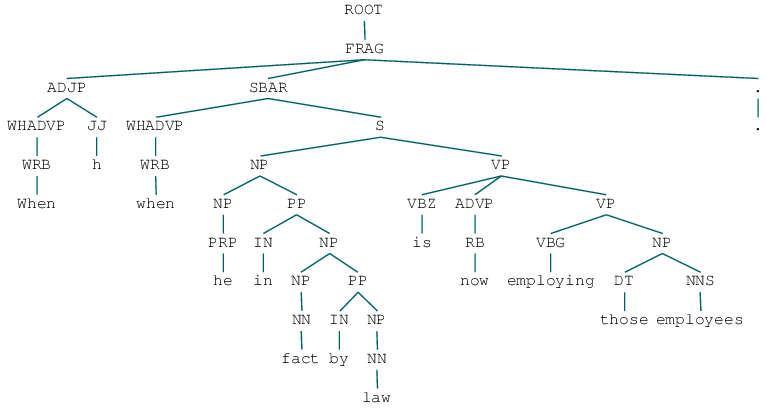

In [9]:
processed_trees[1]

In [10]:
wordspos = []
for t in processed_trees: 
    twords = t.leaves()
    words=[w.lower() for w in twords]
    pos= PreterminalizeTree(t).leaves()
    wordspos+=zip(words,pos)

In [11]:
wordspos[-10:]

[('incidences', 'JJ'),
 ('where', 'WRB'),
 ('he', 'PRP'),
 ('acted', 'VBD'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('same', 'JJ'),
 ('way', 'NN'),
 ('?', '.'),
 ('.', '.')]

##Fix words that were split by the parser

We need to make sure the list of words here is the same as the words column in the dataframe I used to score the stimuli
- contractions with apostrophes "they'll"
- modals "gonna" , "wanna"



In [12]:
count = 0
secondhalfpositions = []
for w in wordspos:
  if re.search(r'[^o]?\'[^c]', w[0]) or re.search(r'^na$', w[0]): #match the apostrophe in split contractions, the NOT 'o' and NOT 'c' are there to exclude 'o'clock' 
     secondhalfpositions.append(count)
     combinedword = wordspos[count-1][0]+w[0] #combine the two halves of the word
     combinedPOS = wordspos[count-1][1]+"-"+w[1] #combine the two POS tags
     wordspos[count-1]=(combinedword, combinedPOS)
  count+=1

Print first 10 examples to see if it looks the way we expect (combined word, followed by second half of contraction)

In [13]:
i=0
for w in wordspos:
    if re.search(r"\'",w[0]) and i<10:
        print w
        i+=1

("he's", 'PRP-VBZ')
("'s", 'VBZ')
("isn't", 'VBZ-RB')
("n't", 'RB')
("don't", 'VB-RB')
("n't", 'RB')
("that's", 'DT-VBZ')
("'s", 'VBZ')
("i'll", 'PRP-MD')
("'ll", 'MD')


Looks good, now we need to delete the second half of the contractions and then run the cell above again

In [14]:
removed_count = 0
for p in secondhalfpositions:
    wordspos.pop(p-removed_count)
    removed_count +=1

Looks good, now fix the the rest of not matching words:
  - 'o' in stimulus 4 "fear is so crippling", in original text it was -o but clearly sounds like 'so' so I changed it in the scoring representation
  
  - multi-digit numbers that are treated as one word in parsed stimuli and multiple words in stimulus text (e.g. 'threequarterinch', 'seventytwo')
  
['o',
'threequarterinch',
'threequarter',
'thirtyone',
'seventytwo',
'twentyeight',
'ninetyeights',
'ninetysixes',
'ninetynine']
    

In [15]:
#First fix 'o' -> 'so' in Stim 4 
[i for i,x in enumerate(wordspos) if x[0] =='o'] # found 'o' is at position [341]

wordspos[376]=('so' , wordspos[376][1]) #have to replace the entire tuple since we can't edit tuple elements

In [16]:
wordspos[376]

('so', 'NN')

##Let's define a function to split and insert new elements 

In [17]:
def SplitValues(position, values, wordslist): #*value would be list of new values for 
    newtuple =(values[0], wordslist[position][1]) 
    wordslist[position] = newtuple
    if len(values)>1:
        for i in range(1,len(values)):
            nexttuple = (values[i], newtuple[1])
            wordslist.insert(position+i, nexttuple)    

##Fix number values 

I'm stepping through each one by one, I didn't do this with a loop because I wanted to  be really careful and clear about the values that I'm changing.


In [18]:
# 'threequarterinch'
pos = [i for i, x in enumerate(wordspos) if x[0] =='threequarterinch'] 
print pos
SplitValues(pos[0], ['three', 'quarter', 'inch'], wordspos)

[566]


###Check that it worked

In [19]:
wordspos[566:569]

[('three', 'JJ'), ('quarter', 'JJ'), ('inch', 'JJ')]

Looks good! Let's continue

In [20]:
# 'threequarter',
pos = [i for i, x in enumerate(wordspos) if x[0] =='threequarter'] 
print pos
SplitValues(pos[0], ['three', 'quarter'], wordspos)

[701]


In [21]:
wordspos[701:705]

[('three', 'NN'), ('quarter', 'NN'), ('acres', 'NNS'), ('of', 'IN')]

In [22]:
# 'thirtyone',
pos = [i for i, x in enumerate(wordspos) if x[0] =='thirtyone']
print pos
SplitValues(pos[0], ['thirty', 'one'], wordspos)

[811]


In [23]:
wordspos[811:815]

[('thirty', 'JJ'), ('one', 'JJ'), ('hours', 'NNS'), ('the', 'DT')]

In [24]:
# 'seventytwo',
pos = [i for i, x in enumerate(wordspos) if x[0] =='seventytwo']
print pos
SplitValues(pos[0], ['seventy', 'two'], wordspos)
wordspos[pos[0]:pos[0]+5]

[994]


[('seventy', 'NN'), ('two', 'NN'), ('okay', 'JJ'), ('.', '.'), ('so', 'IN')]

In [25]:
# 'twentyeight',
pos = [i for i, x in enumerate(wordspos) if x[0] =='twentyeight']
SplitValues(pos[0], ['twenty', 'eight'], wordspos)
wordspos[pos[0]:pos[0]+5]

[('twenty', 'NN'),
 ('eight', 'NN'),
 ('to', 'TO'),
 ('distribute', 'VB'),
 ('throughout', 'IN')]

In [26]:
# 'ninetyeights',
pos = [i for i, x in enumerate(wordspos) if x[0] =='ninetyeights']
print pos
SplitValues(pos[0], ['ninety', 'eights'], wordspos)
wordspos[pos[0]:pos[0]+5]

[1848]


[('ninety', 'NNS'),
 ('eights', 'NNS'),
 ('and', 'CC'),
 ('ninetysixes', 'VBZ'),
 ('i', 'PRP')]

In [27]:
# 'ninetysixes',
pos = [i for i, x in enumerate(wordspos) if x[0] =='ninetysixes']
print pos
SplitValues(pos[0], ['ninety', 'sixes'], wordspos)
wordspos[pos[0]:pos[0]+5]

[1851]


[('ninety', 'VBZ'),
 ('sixes', 'VBZ'),
 ('i', 'PRP'),
 ('put', 'VBD'),
 ('their', 'PRP$')]

In [28]:
# 'ninetynine']
pos = [i for i, x in enumerate(wordspos) if x[0] =='ninetynine']
print pos
SplitValues(pos[0], ['ninety', 'nine'], wordspos)
wordspos[pos[0]:pos[0]+5]

[1883]


[('ninety', 'JJ'), ('nine', 'JJ'), ('.', '.'), ('.', '.'), ('because', 'IN')]

##Check for any additional not matching words


In [29]:
scores = pd.read_csv('/Users/heathersimpson/Documents/Dissertation/Articles/Chp3_IUvsClauseBoundaries/GS_Score_byWord_updated.csv', sep='\t') #The file containing the rest of the experiment data, we need to make sure that the list of words we've extracted from the syntactic parses matches the list of words here, so that we can match up their values for ClauseBoundary 

In [30]:
bysubj = scores.groupby('Subj')
subj0 = bysubj.get_group(0)
scores_words = subj0['Word'].values

In [31]:
print len(scores_words)
scores_words[-10:]

2018


array(['are', 'other', 'incidences', 'where', 'he', 'acted', 'in', 'the',
       'same', 'way'], dtype=object)

In [32]:
scores_words = [w.lower() for w in scores_words]

In [33]:
scores_words[-10:]

['are',
 'other',
 'incidences',
 'where',
 'he',
 'acted',
 'in',
 'the',
 'same',
 'way']

In [34]:
scores_set = set(scores_words)

In [35]:
#wordspos_set = set(wordspos)
diffwords=[y for y,z in wordspos if y not in scores_set];print len(diffwords);diffwords

223


['.',
 '.',
 '.',
 '.',
 '?',
 '?',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '?',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '?',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '?',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '?',
 '?',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.'

##Fix remaining non-matching things

Punctuation and the "footsteps" that was part of a background noise tag in the original transcript

In [36]:
wordspos = [x for x in wordspos if re.match(r"[\'a-z]", x[0])]
diffwords=[y for y,z in wordspos if y not in scores_set];print len(diffwords);diffwords

1


['footsteps']

In [37]:
wordspos = [x for x in wordspos if x[0]!="footsteps"]

In [38]:
diffwords=[y for y,z in wordspos if y not in scores_set];print len(diffwords);diffwords

0


[]

In [39]:
wordspos[-10:]

[('are', 'VBP'),
 ('other', 'JJ'),
 ('incidences', 'JJ'),
 ('where', 'WRB'),
 ('he', 'PRP'),
 ('acted', 'VBD'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('same', 'JJ'),
 ('way', 'NN')]

The sets match, now check that every element matches

In [40]:
print len(scores_words)
print len([w[1] for w in wordspos])

2018
2020


##Find remaining mismatching elements

In [41]:
def checkforDiffs(list1, list2): #list1 here is words, list2 is subj0.Word
  i = 0
  while i<len(list2):
      if list1[i][0]!=list(list2)[i]: break  
      else:
          print ("Matched at pos %d" %i)
      i+=1
  if i<len(list2):
      print str(i) + " " + list1[i][0] + "  " + list(list2)[i]
  else: 
      print "Reached end oflist2"

In [42]:
checkforDiffs(wordspos, scores_words)

Matched at pos 0
Matched at pos 1
Matched at pos 2
Matched at pos 3
Matched at pos 4
Matched at pos 5
Matched at pos 6
Matched at pos 7
Matched at pos 8
Matched at pos 9
Matched at pos 10
Matched at pos 11
Matched at pos 12
Matched at pos 13
Matched at pos 14
Matched at pos 15
Matched at pos 16
Matched at pos 17
Matched at pos 18
Matched at pos 19
Matched at pos 20
Matched at pos 21
Matched at pos 22
Matched at pos 23
Matched at pos 24
Matched at pos 25
Matched at pos 26
Matched at pos 27
Matched at pos 28
Matched at pos 29
Matched at pos 30
Matched at pos 31
Matched at pos 32
Matched at pos 33
Matched at pos 34
Matched at pos 35
Matched at pos 36
Matched at pos 37
Matched at pos 38
Matched at pos 39
Matched at pos 40
Matched at pos 41
Matched at pos 42
Matched at pos 43
Matched at pos 44
Matched at pos 45
Matched at pos 46
Matched at pos 47
Matched at pos 48
Matched at pos 49
Matched at pos 50
Matched at pos 51
Matched at pos 52
Matched at pos 53
Matched at pos 54
Matched at pos 55
Ma

Remove: "Okay" (missing from GS scores list but in wordspos)

In [43]:
wordspos.pop(1344)

('okay', 'UH')

In [44]:
checkforDiffs(wordspos, scores_words)

Matched at pos 0
Matched at pos 1
Matched at pos 2
Matched at pos 3
Matched at pos 4
Matched at pos 5
Matched at pos 6
Matched at pos 7
Matched at pos 8
Matched at pos 9
Matched at pos 10
Matched at pos 11
Matched at pos 12
Matched at pos 13
Matched at pos 14
Matched at pos 15
Matched at pos 16
Matched at pos 17
Matched at pos 18
Matched at pos 19
Matched at pos 20
Matched at pos 21
Matched at pos 22
Matched at pos 23
Matched at pos 24
Matched at pos 25
Matched at pos 26
Matched at pos 27
Matched at pos 28
Matched at pos 29
Matched at pos 30
Matched at pos 31
Matched at pos 32
Matched at pos 33
Matched at pos 34
Matched at pos 35
Matched at pos 36
Matched at pos 37
Matched at pos 38
Matched at pos 39
Matched at pos 40
Matched at pos 41
Matched at pos 42
Matched at pos 43
Matched at pos 44
Matched at pos 45
Matched at pos 46
Matched at pos 47
Matched at pos 48
Matched at pos 49
Matched at pos 50
Matched at pos 51
Matched at pos 52
Matched at pos 53
Matched at pos 54
Matched at pos 55
Ma

Remove 'Right' from GSscores list

In [45]:
wordspos.pop(1574)

('right', 'RB')

In [46]:
checkforDiffs(wordspos, scores_words)

Matched at pos 0
Matched at pos 1
Matched at pos 2
Matched at pos 3
Matched at pos 4
Matched at pos 5
Matched at pos 6
Matched at pos 7
Matched at pos 8
Matched at pos 9
Matched at pos 10
Matched at pos 11
Matched at pos 12
Matched at pos 13
Matched at pos 14
Matched at pos 15
Matched at pos 16
Matched at pos 17
Matched at pos 18
Matched at pos 19
Matched at pos 20
Matched at pos 21
Matched at pos 22
Matched at pos 23
Matched at pos 24
Matched at pos 25
Matched at pos 26
Matched at pos 27
Matched at pos 28
Matched at pos 29
Matched at pos 30
Matched at pos 31
Matched at pos 32
Matched at pos 33
Matched at pos 34
Matched at pos 35
Matched at pos 36
Matched at pos 37
Matched at pos 38
Matched at pos 39
Matched at pos 40
Matched at pos 41
Matched at pos 42
Matched at pos 43
Matched at pos 44
Matched at pos 45
Matched at pos 46
Matched at pos 47
Matched at pos 48
Matched at pos 49
Matched at pos 50
Matched at pos 51
Matched at pos 52
Matched at pos 53
Matched at pos 54
Matched at pos 55
Ma

Ok everything matches!

In [47]:
pos = [w[1] for w in wordspos]

In [48]:
pos[-10:]

['VBP', 'JJ', 'JJ', 'WRB', 'PRP', 'VBD', 'IN', 'DT', 'JJ', 'NN']

##Create new subj0 dataframe with POS

In [49]:
subj0 = pd.DataFrame(data ={'Word':subj0['Word'], 'Subj':subj0['Subj'],'Stim':subj0['StimulusID'], 'POS':pos})

## Now use existing function to create WordPairs data (from ExtractingWordPairsData.py)

define ReturnWordPairs: A function to return values for sequences of 2 words from 
the same Subject for a specified column from the dataframe

In [50]:
def ReturnWordPairs(scoresdf, colname, identitycols):  
  count = 0
  pairvals = []
  while count < len(scoresdf):
    for n in range(len(scoresdf)):
      curr_pairvals = scoresdf.iloc[n:n+2] #access two rows in sequence, range with : is exclusive of the last number so use n+2
      uids=[len(curr_pairvals[id].unique()) for id in identitycols]
      if sum(uids)==len(identitycols): #the above line checks that the Subject and Stimulus ID values are the same for both words, so we don't compare words across subjects and stimuli. This way, the entire scores dataframe could be used if desired, rather than having to group it by subject or stimuli 
        pairvals.append(curr_pairvals[colname].values)
      count += 1
  if len(pairvals[-1:])<2: #sometimes the final value may be of length 1, such as if the dataset length was odd. If so, remove that final value.
    pairvals = pairvals[:-1]
  return pairvals #returns list of arrays, each containing the list of paired col values

I'll run this on the Word variable so I can check the length of our POS variable against that

In [51]:
POSpairs = []
for vals in ReturnWordPairs(subj0, 'POS',['Stim', 'Subj']):
        vals = [str(v) for v in vals]
        POSpairs.append("-".join(vals))
#POSpairs = POSpairs[:-1]
print len(POSpairs)

1964


In [52]:
print POSpairs[-10:]
print len(subj0)

['EX-VBP', 'VBP-JJ', 'JJ-JJ', 'JJ-WRB', 'WRB-PRP', 'PRP-VBD', 'VBD-IN', 'IN-DT', 'DT-JJ', 'JJ-NN']
2018


##Add POS column to WordPairs CSV file

In [63]:
WordPairs = pd.read_csv("/Users/heathersimpson/Documents/Dissertation/Articles/Chp3_IUvsClauseBoundaries/WordPairsScores.csv", sep="\t", index_col=0)
WordPairs.head()

,CLCount,IUCount,IUStatus,MatchStatus,StimID,Subject,WCount,Word,WordPosition,Matching,WithinIU,ClauseBoundary,Boundary,BoundaryType
0,10,14,acrossIU,bothforgotten,0,0,71,Then-when,0.007042,1,0,0,1,IU
1,10,14,withinIU,bothforgotten,0,0,71,when-when,0.021127,1,1,0,0,None
2,10,14,withinIU,bothforgotten,0,0,71,when-a,0.035211,1,1,1,1,Clause
3,10,14,withinIU,bothforgotten,0,0,71,a-person,0.049296,1,1,0,0,None
4,10,14,withinIU,bothforgotten,0,0,71,person-fills,0.063380,1,1,0,0,None


In [54]:
print len(WordPairs[WordPairs['Subject']==0])
print len(POSpairs)

1964
1964


Lengths match, so now check that the order of stim/subj matches, if so duplicate POSpairs to be same length as WordPair

In [64]:
WordPairs[WordPairs['Subject']==1].index[0]

70

Looks like all Subjs are cycled through for each Stim, so we need to sort so order matches Wordpos (all stims for 1 subj)

In [69]:
WordPairs.sort_values(by=['Subject', 'StimID','WordPosition'], ascending=True, inplace=True)

In [73]:
WordPairs[70:100]

,CLCount,IUCount,IUStatus,MatchStatus,StimID,Subject,WCount,Word,WordPosition,Matching,WithinIU,ClauseBoundary,Boundary,BoundaryType
7070,11,14,withinIU,bothforgotten,1,0,76,don't-believe,0.006579,1,1,0,0,None
7071,11,14,withinIU,bothforgotten,1,0,76,believe-in,0.019737,1,1,0,0,None
7072,11,14,withinIU,bothforgotten,1,0,76,in-that,0.032895,1,1,0,0,None
7073,11,14,acrossIU,bothforgotten,1,0,76,that-That's,0.046053,1,0,1,1,Both
7074,11,14,withinIU,bothforgotten,1,0,76,That's-probably,0.059211,1,1,0,0,None
7075,11,14,withinIU,bothforgotten,1,0,76,probably-why,0.072368,1,1,0,0,None
7076,11,14,withinIU,bothforgotten,1,0,76,why-I'll,0.085526,1,1,1,1,Clause
7077,11,14,withinIU,bothforgotten,1,0,76,I'll-always,0.098684,1,1,0,0,None
7078,11,14,withinIU,bothforgotten,1,0,76,always-be,0.111842,1,1,0,0,None
7079,11,14,withinIU,bothforgotten,1,0,76,be-poor,0.125000,1,1,0,0,None


In [76]:
print len(WordPairs)
print float(len(WordPairs))/float(len(POSpairs))

198364
101.0


In [77]:
WordPairs['POS']= POSpairs*101

In [79]:
WordPairs[-5:]

,CLCount,IUCount,IUStatus,MatchStatus,StimID,Subject,WCount,Word,WordPosition,Matching,WithinIU,ClauseBoundary,Boundary,BoundaryType,POS
198359,7,10,withinIU,bothremembered,53,101,44,he-acted,0.875000,1,1,0,0,None,PRP-VBD
198360,7,10,withinIU,bothremembered,53,101,44,acted-in,0.897727,1,1,0,0,None,VBD-IN
198361,7,10,withinIU,bothremembered,53,101,44,in-the,0.920455,1,1,0,0,None,IN-DT
198362,7,10,withinIU,bothremembered,53,101,44,the-same,0.943182,1,1,0,0,None,DT-JJ
198363,7,10,withinIU,bothremembered,53,101,44,same-way,0.965909,1,1,0,0,None,JJ-NN


###Write updated WordPairs to file

In [81]:
pd.DataFrame.to_csv(WordPairs, path_or_buf="../WordPairsScores_withPOS.csv", sep='\t', index=False, columns=WordPairs.columns)